# Feature_Distribution_for_MNIST
MNIST & LeNet-5 implementation

<center><img src="https://blog.paperspace.com/content/images/size/w1000/2021/10/image-17.png" width="75%" height="75%"/></center>

In [1]:
import numpy as np
import torch
from torch import nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
# change the max. print value
np.set_printoptions(threshold=1000000, suppress=True)

In [2]:
# 固定亂數種子
torch.manual_seed(1)
torch.cuda.manual_seed_all(1)

In [3]:
# 數據預處理
transform = transforms.Compose([
#     transforms.RandomResizedCrop(224),# 對圖像進行隨機裁減
#     transforms.RandomRotation(20),# 對圖像進行隨機旋轉
#     transforms.RandomHorizontalFlip(p=0.5),# 對圖像進行隨機水平翻轉
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()# 變成tensor格式
#     transforms.Normalize(
#         mean=[0.485, 0.456, 0.406],
#         std=[0.229, 0.224, 0.225])
]) # 數據增強

# 讀取數據
root = "./data/custom/MNIST"
train_data = datasets.ImageFolder(root + "/train",transform)
test_data = datasets.ImageFolder(root + "/test",transform)

In [4]:
batch_size = 256
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)
feature_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False)

In [5]:
classes = train_data.classes
classes_index = train_data.class_to_idx
print(classes)
print(classes_index)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}


In [6]:
# 測試CUDA能否使用
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [7]:
# 轉換成CUDA能讀的格式
# generate data in parallel with PyTorch
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([256, 1, 28, 28])
Shape of y: torch.Size([256]) torch.int64


In [8]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            # nn.Conv2d(1,6,5,1,2): 通道數，輸出數，捲積，步長，在圖片旁邊補0(幾圈)
            nn.Conv2d(1,6,5,1,2), # C1:6@28*28
            nn.Tanh(), 
            nn.MaxPool2d(2,2), # S2:6@14*14
            nn.Conv2d(6,16,5), # C3:16@10*10
            nn.Tanh(),
            nn.MaxPool2d(2,2), # S4:16@5*5
        )
        self.classifier = nn.Sequential(
            nn.Linear(16*5*5,120), # C5:120
            nn.Sigmoid(),
            nn.Linear(120,84), # F6:84
            nn.Sigmoid(),
            nn.Linear(84,10) # Output:10 (class[0]~[9])
        )
    def forward(self,x):
        x = self.features(x)
        x = x.view(x.size()[0],-1)
        x = self.classifier(x)
        return x

In [9]:
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        # Extract Net Feature Layers
        self.features = list(model.features)
        self.features = nn.Sequential(*self.features)
        # Convert the image into one-dimensional vector
        self.flatten = nn.Flatten()
        # Extract the first part of fully-connected layer from Net
        self.fc = model.classifier[0]
    def forward(self, x):
        # It will take the input 'x' until it returns the feature vector called 'out'
        out = self.features(x)
        out = self.flatten(out)
        out = self.fc(out) 
        return out 

# Initialize the model
model = LeNet().to(device)
new_model = FeatureExtractor(model)

# Change the device to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
new_model = new_model.to(device)

In [10]:
model

LeNet(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [11]:
new_model

FeatureExtractor(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=400, out_features=120, bias=True)
)

In [12]:
features = []
step = 64
size = len(feature_dataloader.dataset)
model.train()
for batch, (X, y) in enumerate(feature_dataloader):
    X = X.to(device)# 讀圖片跟labels
    # Systematic Sampling
    sX = X[:len(X)-1:step]
    model.eval() # 測試模式，不做反向傳播
    with torch.no_grad(): # 不需要計算梯度
     # Compute prediction error
        feature = new_model(sX)
#         feature = new_model(X)
    if batch % 100 == 0: # 顯示進度條
        current = batch * len(X)
        print(f"Feature Extractor: [{current:>5d}/{size:>5d}]")   
    # Convert to NumPy Array, Reshape it, and save it to features variabl
    features.append(feature.cpu().detach().numpy())    

Feature Extractor: [    0/60000]
Feature Extractor: [25600/60000]
Feature Extractor: [51200/60000]


In [13]:
# Convert to NumPy Array
# 由於資料是不規則numpy因此會報錯，這裡因美觀我把它關掉
np.warnings.filterwarnings('ignore', category = np.VisibleDeprecationWarning)
featuresdata = np.array(features)
# 因為資料不平整，要用此方法去處理成一維numpy
import itertools
featureslist =list(itertools.chain(*featuresdata))

In [14]:
# 驗證輸出的資料量是否正確
# print(f"batch_size/step: {batch_size/step}",f"\n")
# print(f"batch[0]: ",len(featuresdata[0]))
print(f"Theoretical Value: {len(featuresdata[0]) * (len(featuresdata)-1) + len(featuresdata[234])}" )
print(f"Actual value: {len(featureslist)}")

Theoretical Value: 938
Actual value: 938


In [15]:
print("Theoretical out_features: 120")
print(f"Actual out_features: {len(featureslist[0])}")

Theoretical out_features: 120
Actual out_features: 120


In [16]:
# sample 4 features

list1, list2, list3, list4 = [], [], [], []

for i in range (len(featureslist)):
    list1.append(featureslist[i][0])
for j in range (len(featureslist)):
    list2.append(featureslist[j][29])
for k in range (len(featureslist)):
    list3.append(featureslist[k][59])
for l in range (len(featureslist)):
    list4.append(featureslist[l][119])

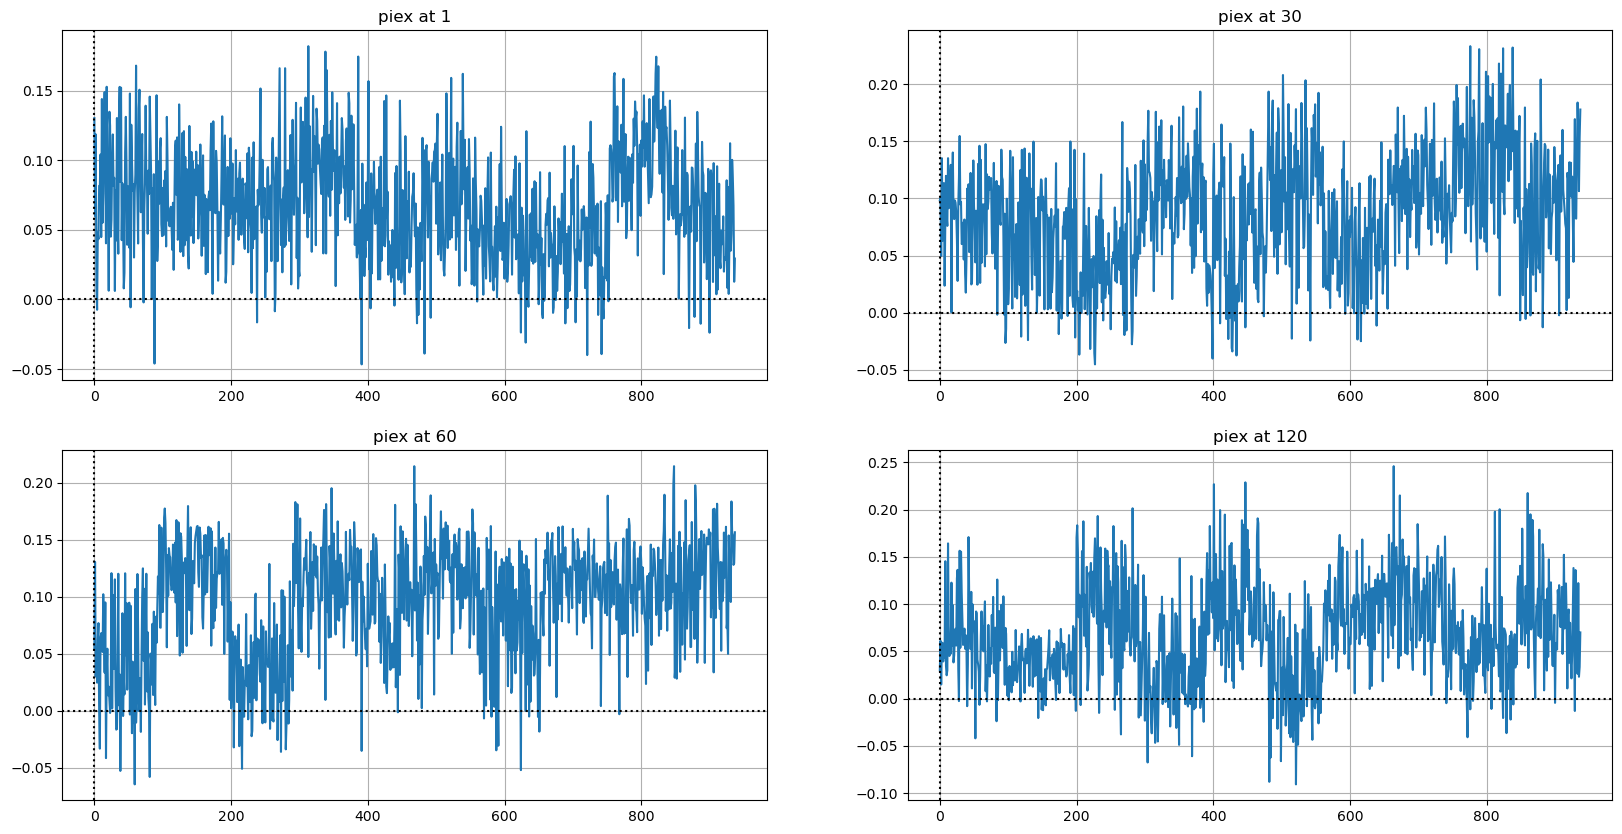

In [17]:
import matplotlib.pyplot as plt
X = np.linspace(0, (len(featureslist)-1), len(featureslist))
f1 = plt.figure(figsize=(20,10))

ax1 = f1.add_subplot(221)
ax1.plot(X, list1)
ax1.axvline(x = 0, color='black', linestyle=":")
ax1.axhline(y = 0, color='black', linestyle=":")
plt.title("piex at 1")
plt.grid(True)

ax2 = f1.add_subplot(222)
ax2.plot(X, list2)
ax2.axvline(x = 0, color='black', linestyle=":")
ax2.axhline(y = 0, color='black', linestyle=":")
plt.title("piex at 30")
plt.grid(True)

ax3 = f1.add_subplot(223)
ax3.plot(X, list3)
ax3.axvline(x = 0, color='black', linestyle=":")
ax3.axhline(y = 0, color='black', linestyle=":")
plt.title("piex at 60")
plt.grid(True)

ax4 = f1.add_subplot(224)
ax4.plot(X, list4)
ax4.axvline(x = 0, color='black', linestyle=":")
ax4.axhline(y = 0, color='black', linestyle=":")
plt.title("piex at 120")
plt.grid(True)

In [18]:
lists1= np.sort(list1)
lists2= np.sort(list2)
lists3= np.sort(list3)
lists4= np.sort(list4)

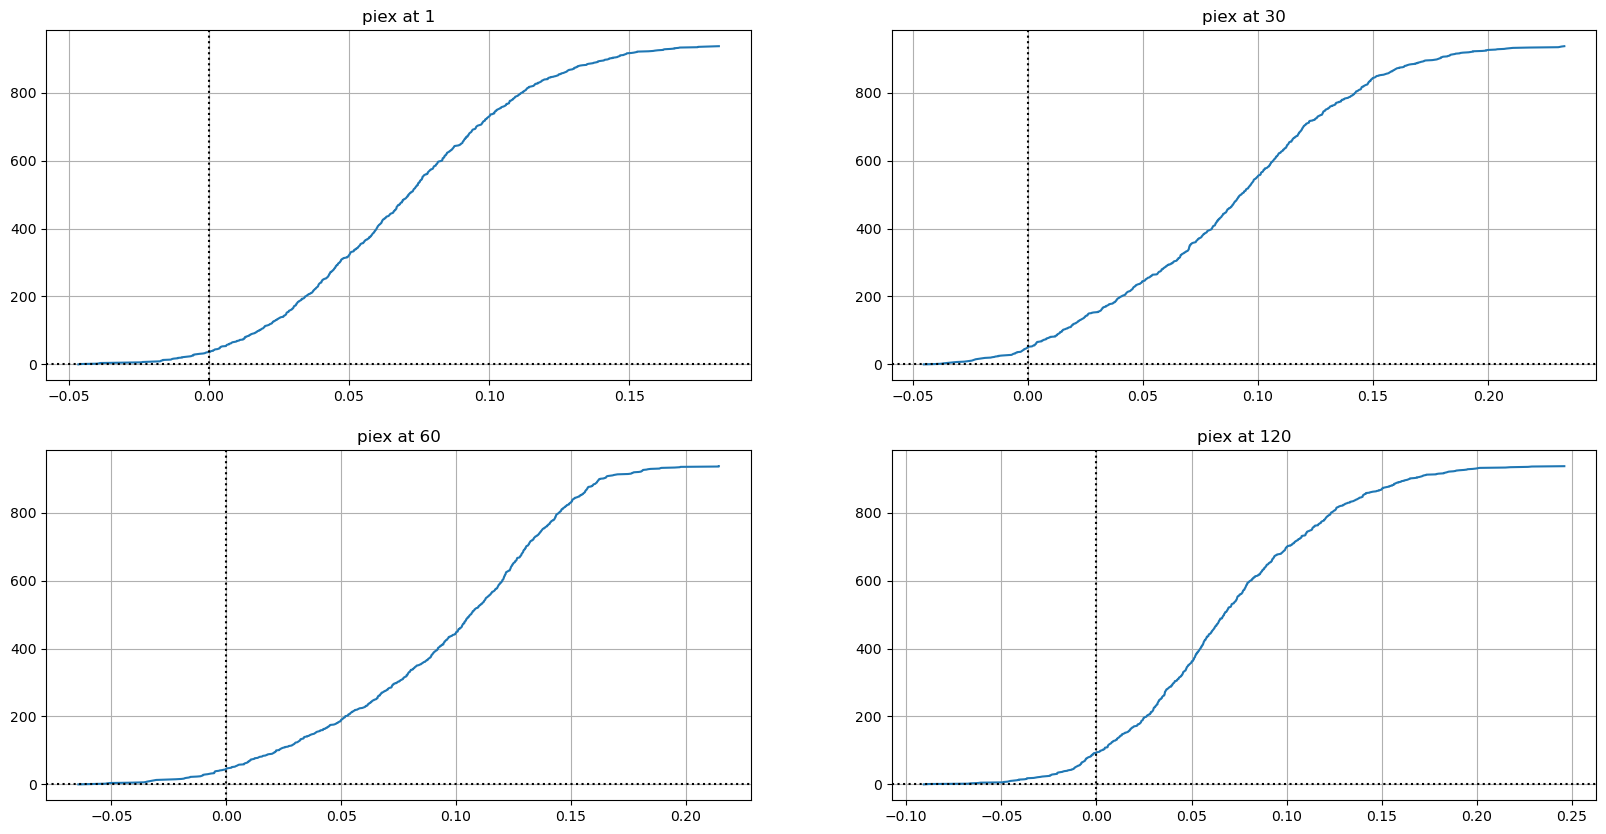

In [19]:
import matplotlib.pyplot as plt

Y = np.linspace(0, (len(featureslist)-1), len(featureslist))
f1 = plt.figure(figsize=(20,10))

ax1 = f1.add_subplot(221)
ax1.plot(lists1, Y)
ax1.axvline(x = 0, color='black', linestyle=":")
ax1.axhline(y = 0, color='black', linestyle=":")
plt.title("piex at 1")
plt.grid(True)

ax2 = f1.add_subplot(222)
ax2.plot(lists2, Y)
ax2.axvline(x = 0, color='black', linestyle=":")
ax2.axhline(y = 0, color='black', linestyle=":")
plt.title("piex at 30")
plt.grid(True)

ax3 = f1.add_subplot(223)
ax3.plot(lists3, Y)
ax3.axvline(x = 0, color='black', linestyle=":")
ax3.axhline(y = 0, color='black', linestyle=":")
plt.title("piex at 60")
plt.grid(True)

ax4 = f1.add_subplot(224)
ax4.plot(lists4 ,Y)
ax4.axvline(x = 0, color='black', linestyle=":")
ax4.axhline(y = 0, color='black', linestyle=":")
plt.title("piex at 120")
plt.grid(True)

In [20]:
# lr = 1e-3
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# def train(dataloader, model, loss_fn, optimizer):
#     size = len(dataloader.dataset)
#     model.train()
#     for batch, (X, y) in enumerate(dataloader):
#         X, y = X.to(device), y.to(device)

#         # Compute prediction error
#         pred = model(X)
#         loss = loss_fn(pred, y)

#         # Backpropagation
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         if batch % 100 == 0:
#             loss, current = loss.item(), batch * len(X)
#             print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# def test(dataloader, model, loss_fn):
#     size = len(dataloader.dataset)
#     num_batches = len(dataloader)
#     model.eval()
#     test_loss, correct = 0, 0
#     with torch.no_grad():
#         for X, y in dataloader:
#             X, y = X.to(device), y.to(device)
#             pred = model(X)
#             test_loss += loss_fn(pred, y).item()
#             correct += (pred.argmax(1) == y).type(torch.float).sum().item()
#     test_loss /= num_batches
#     correct /= size
#     print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [21]:
# epochs = 10
# for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
#     train(train_dataloader, model, loss_fn, optimizer)
#     test(test_dataloader, model, loss_fn)
# print("Done!")

Epoch 1
-------------------------------
loss: 2.316251  [    0/60000]
loss: 1.017451  [25600/60000]
loss: 0.330144  [51200/60000]
Test Error: 
 Accuracy: 94.4%, Avg loss: 0.274162 

Epoch 2
-------------------------------
loss: 0.242968  [    0/60000]
loss: 0.216021  [25600/60000]
loss: 0.159021  [51200/60000]
Test Error: 
 Accuracy: 97.2%, Avg loss: 0.109327 

Epoch 3
-------------------------------
loss: 0.092959  [    0/60000]
loss: 0.083048  [25600/60000]
loss: 0.053052  [51200/60000]
Test Error: 
 Accuracy: 98.0%, Avg loss: 0.074497 

Epoch 4
-------------------------------
loss: 0.083333  [    0/60000]
loss: 0.043132  [25600/60000]
loss: 0.095785  [51200/60000]
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.061457 

Epoch 5
-------------------------------
loss: 0.056252  [    0/60000]
loss: 0.054860  [25600/60000]
loss: 0.051495  [51200/60000]
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.054035 

Epoch 6
-------------------------------
loss: 0.044055  [    0/60000]
loss: 0.029094  [256